# Country specific Value of Statistical Life (VSL) 
------
<div align="right"><i>August 7th 2019</i></div>

The following notebook calculates the VSL for each country based on the *1990 US EPA estimate* of the value of statistical life (VSL). 

The input data required for the subsequent calculations are as follows:

- VSL for the US in 1990 based on the EPA Weibull distribution
> Obtain parameters from [EPA Guidelines on Preparing Economic Analyses](https://www.epa.gov/environmental-economics/guidelines-preparing-economic-analyses)
- The real GDP per capita of the US in the target year and the base year (1990)
> Obtain from the Economic Research website of the [Federal Reserve Bank in St Louis](https://fred.stlouisfed.org/series/A939RX0Q048SBEA#0)
- The GDP deflator for the US in the dollar year and the base year (1990)
> Obtain from the Economic Research website of the [Federal Reserve Bank in St Louis](https://fred.stlouisfed.org/series/A939RX0Q048SBEA#0)
- The GDP per capita PPP of the US and all the countries we wish to calculate it for
> Obtain from the [World Bank](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD)


-------

#### Standard imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as io
%matplotlib inline

#### Read in US data from CSV file

In [45]:
# Read in Data based on the Federal Reserve Bank of St Louis:
#        https://fred.stlouisfed.org/series/A939RX0Q048SBEA#0

# Real GDP per capita is in chained 2012 US$
# GDP deflator base year is set to 2009

df = pd.read_csv('fredgraph.csv',
                 names= ['DATE', 'Real_GDP_PC','GDP_deflator'],
                 parse_dates=True,
                 skiprows=[0])

df['Year'] = pd.DatetimeIndex(df['DATE']).year
df = df.drop(['DATE'],axis=1)

In [29]:
df.head()

,Real_GDP_PC,GDP_deflator,Year
0,14118.25,12.91147,1947
1,14447.50,13.63566,1948
2,14120.25,13.61487,1949
3,15092.25,13.77644,1950
4,16032.75,14.76036,1951


## Calculating US-VSL for a given year based on 1990 EPA Weibull dist params

In order to calculate the VSL in a particular year we use the following formula,

$$VSL_{\text{US,val year, \$ year}} = VSL_{\text{US},1990,1990}\times\left(\frac{GDP_{\text{PC, val year}}}{GDP_{PC, 1990}}\right)^\varepsilon \times \left(\frac{GDP_{\text{deflator, \$ year}}}{GDP_{\text{delfator}, 1990}}\right) $$

where $\varepsilon$ is the income elasticity and the **real GDP per capita** is used.

To obtain the baseline VSL for the US, we use a Weibull distribution with a **scale of 7.75** and a **shape of 1.509**. The values for the distribution are obtained from Appendix B of the [US EPA Guidelines for Preparing Economic Analyses](https://www.epa.gov/sites/production/files/2017-09/documents/ee-0568-22.pdf)

*[EPA](https://www.epa.gov/sites/production/files/2017-09/documents/ee-0568-07.pdf) currently recommends a default central “value of statistical life” (VSL) of __$ 7.9 million (in 2008 dollars)__ to value reduced mortality for all programs and policies.*


Mean VSL US = 4.80
Std Dev = 3.24
[5th, 95th] perctile = [ 0.7463597  11.01589703]


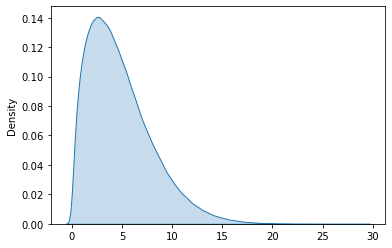

In [6]:
scale = 5.32
shape = 1.51
VSL_US_1990_dist = scale*np.random.weibull(shape, 1000000)
sns.kdeplot(VSL_US_1990_dist,shade=True)

VSL_US_1990 = np.mean(VSL_US_1990_dist)
prctile = np.percentile(VSL_US_1990_dist,[5,95])
std_dev = np.std(VSL_US_1990_dist)

print("Mean VSL US = {0:.2f}\nStd Dev = {2:.2f}\n[5th, 95th] perctile = {1}".format(VSL_US_1990,prctile,std_dev))

In [48]:
Target_Val_year = 2019
Dollar_year     = 2019
Base_year       = 1990
Income_elasticity_1 = 0.7
Income_elasticity_2 = 1.5


Real_GDP_PC_target_yr = df.loc[df["Year"] == Target_Val_year, 'Real_GDP_PC'].values
Real_GDP_PC_base_yr   = df.loc[df["Year"] == Base_year, 'Real_GDP_PC'].values

GDP_def_dollar_yr   = df.loc[df["Year"] == Dollar_year, 'GDP_deflator'].values
GDP_def_base_yr     = df.loc[df["Year"] == Base_year, 'GDP_deflator'].values

(GDP_def_dollar_yr / GDP_def_base_yr)*\
                    (Real_GDP_PC_target_yr / Real_GDP_PC_base_yr)**Income_elasticity_1

array([2.37963365])

In [46]:
Dollar_year     = 2018
Base_year       = 1990
Real_GDP_PC_base_yr   = df.loc[df["Year"] == Base_year, 'Real_GDP_PC'].values
GDP_def_dollar_yr   = df.loc[df["Year"] == Dollar_year, 'GDP_deflator'].values
GDP_def_base_yr     = df.loc[df["Year"] == Base_year, 'GDP_deflator'].values

Income_elasticity_1 = 0.7
Income_elasticity_2 = 1.5

## Calculating Country Specific VSLs
$$ VSL_{country = i } = VSL_{US,val\ year,\$\ year} \times \text{IR}_{i}^\varepsilon $$

where the Income Ratio (IR) is defined as,

$$ \text{IR}_i = \frac{GDP_{PPP, country = i}}{GDP_{PPP, US}} $$

In [40]:
# GDP_PPP from WorldBank in constant 2011 International $ 
#  https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD
#  Indicator Code = NY.GDP.PCAP.PP.KD
#  Last updated 7/10/2019
for Target_Val_year in range(1997, 2019):
    Real_GDP_PC_target_yr = df.loc[df["Year"] == Target_Val_year, 'Real_GDP_PC'].values
    VSL_US_target_dollar_year = VSL_US_1990_dist * (GDP_def_dollar_yr / GDP_def_base_yr)*\
                        (Real_GDP_PC_target_yr / Real_GDP_PC_base_yr)**Income_elasticity_1

    WBK_GDP_PPP = pd.read_excel('WBK_GDP_PPP.xls', sheet_name='Data', skiprows=[0,1,2])

    US_GDP_PPP_target_yr = WBK_GDP_PPP.loc[ WBK_GDP_PPP["Country"] == 'United States', 
                                           str(Target_Val_year) ].values
    # Calculate Income Ratio (IR)
    IR   = WBK_GDP_PPP[str(Target_Val_year)].values/US_GDP_PPP_target_yr
    IR_india = IR[107:108]
    # Calculate VSL for India
    VSLs = (IR_india**Income_elasticity_2)*VSL_US_target_dollar_year
    io.savemat(f'/Users/ruoyulan/Desktop/VSL_2/VSL_{Target_Val_year}', {'VSLs': VSLs})

# plot the data
# VSL_IND = np.mean(VSLs)
# prctile = np.percentile(VSLs,[5,95])
# std_dev = np.std(VSLs)

# print("Mean VSL India = {0:.2f}\nStd Dev = {2:.2f}\n[5th, 95th] perctile = {1}".format(VSL_IND,prctile,std_dev))
# sns.kdeplot(VSLs,shade=True)

In [41]:
np.mean(VSLs)

0.48653606678032907

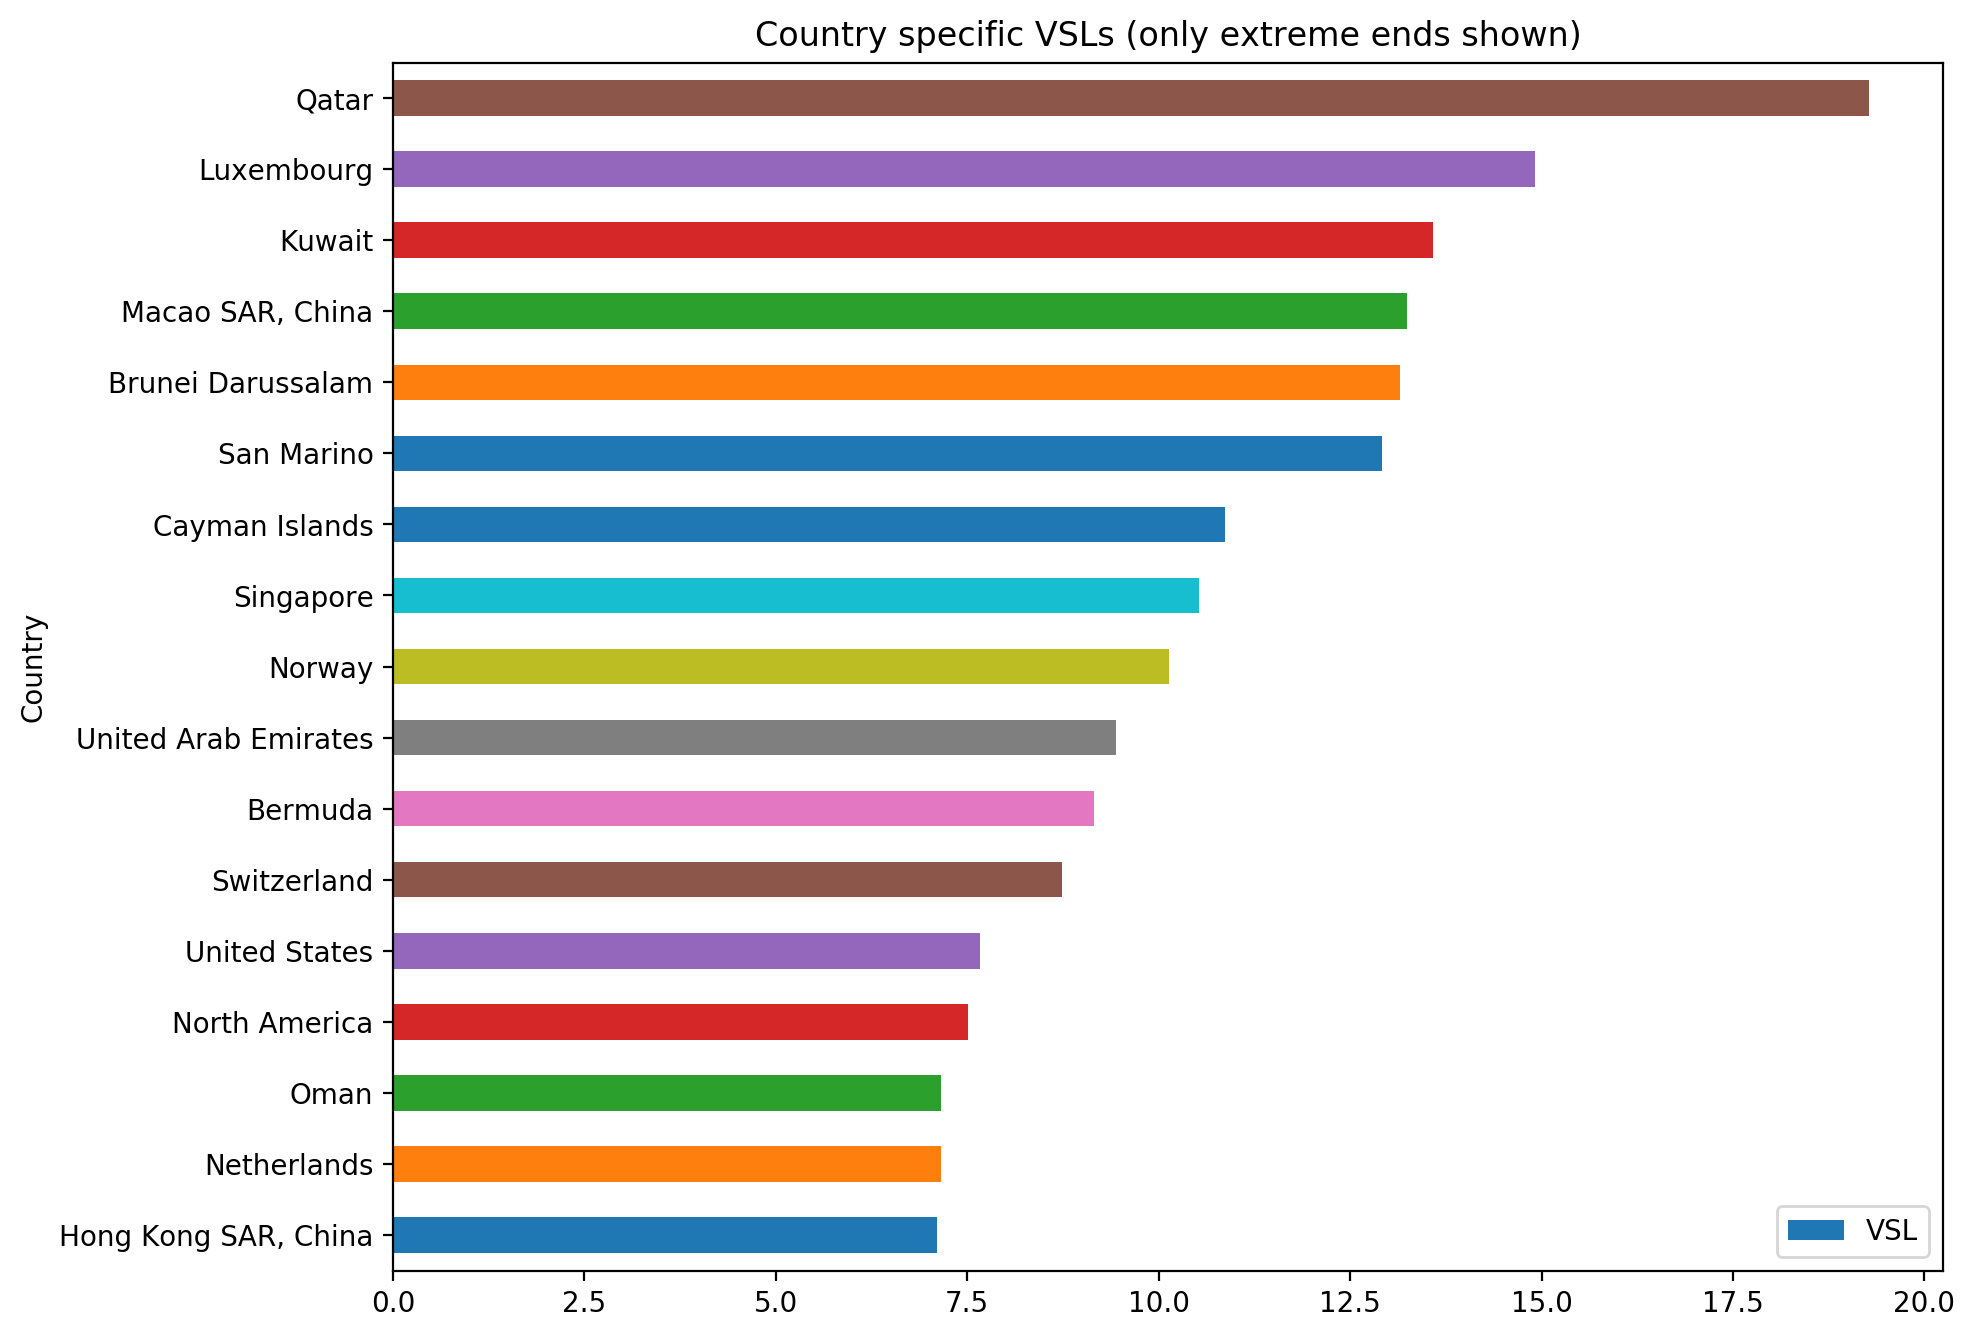

In [94]:
# Visualize 
fig, ax = plt.subplots(figsize= (10,8),dpi = 200)
Extremes_VSL.plot.barh(ax=ax, x='Country',y='VSL')
#VSLs.plot.barh(ax=ax, x='Country',y='VSL')
plt.title('Country specific VSLs (only extreme ends shown)')
plt.show()